In [1]:
# Import dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from kerastuner.tuners import RandomSearch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

C:\Users\johbr\AppData\Local\Temp\ipykernel_6808\138741423.py:5: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
# import data
df = pd.read_csv("../resources/ames_housing_data.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# disable pandas display truncation, show neighborhood 'Blueste', which has only two values
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# filter and display as df
blueste_df = df[df['Neighborhood'] == 'Blueste']
display(blueste_df)

# reset display options
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

# drop Blueste
print(len(df))
df.drop(df[df['Neighborhood'] == 'Blueste'].index, inplace=True)
print(len(df))


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
599,600,160,RM,24.0,1950,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Blueste,Norm,Norm,Twnhs,2Story,6,6,1980,1980,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,Gd,CBlock,Gd,TA,No,LwQ,81,GLQ,612,23,716,GasA,TA,Y,SBrkr,716,840,0,1556,1,0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1980.0,Fin,2,452,TA,TA,Y,161,0,0,0,0,0,NaN,GdPrv,NaN,0,7,2008,COD,Normal,151000
956,957,160,RM,24.0,1300,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Blueste,Norm,Norm,TwnhsE,2Story,6,6,1980,1980,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,No,ALQ,285,Unf,0,276,561,GasA,TA,Y,SBrkr,561,668,0,1229,0,0,1,1,2,1,TA,5,Typ,1,TA,Attchd,1980.0,Fin,2,462,TA,TA,Y,150,0,0,0,0,0,NaN,GdPrv,NaN,0,5,2009,WD,Normal,124000


1460
1458


what's going on here? it's the neighborhood with only two values, and it freaks out the scaler. something is wrong. i'm dropping this neighborhood

In [4]:
# display numerical features
df_num = df.select_dtypes(include=["float64", "int64"])
df_num.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


## Data Preprocessing

In [5]:
# fill missing values with the mean for each numerical feature
df = df.fillna(df_num.mean())

In [6]:
# drop 'Id'
df = df.drop("Id", axis=1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
df = df[['OverallQual', 'OverallCond', 'GrLivArea', 'TotRmsAbvGrd', 'YearBuilt', 'Neighborhood', 'SaleCondition', 'SalePrice']]
df.head()

,OverallQual,OverallCond,GrLivArea,TotRmsAbvGrd,YearBuilt,Neighborhood,SaleCondition,SalePrice
0,7,5,1710,8,2003,CollgCr,Normal,208500
1,6,8,1262,6,1976,Veenker,Normal,181500
2,7,5,1786,6,2001,CollgCr,Normal,223500
3,7,5,1717,7,1915,Crawfor,Abnorml,140000
4,8,5,2198,9,2000,NoRidge,Normal,250000


In [8]:
df = df[df['SaleCondition'] == 'Normal']

In [9]:
# drop outliers (rooms with more than 4000 square feet)
df = df[df.GrLivArea <= 4000]

In [12]:
# get_dummies for categorical data
dummies = pd.get_dummies(df)
dummies.head()

,OverallQual,OverallCond,GrLivArea,TotRmsAbvGrd,YearBuilt,SalePrice,Neighborhood_Blmngtn,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,...,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,SaleCondition_Normal
0,7,5,1710,8,2003,208500,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,6,8,1262,6,1976,181500,False,False,False,False,...,False,False,False,False,False,False,False,False,True,True
2,7,5,1786,6,2001,223500,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,8,5,2198,9,2000,250000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
5,5,5,1362,5,1993,143000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


SalePrice               1.000000
OverallQual             0.792207
GrLivArea               0.736332
TotRmsAbvGrd            0.528494
YearBuilt               0.504184
Neighborhood_NoRidge    0.368556
Neighborhood_NridgHt    0.322167
Neighborhood_StoneBr    0.155010
Neighborhood_Timber     0.145744
Neighborhood_Somerst    0.131268
Neighborhood_CollgCr    0.098121
Neighborhood_ClearCr    0.097717
Neighborhood_Veenker    0.091102
Neighborhood_Crawfor    0.085845
Neighborhood_NWAmes     0.066824
Neighborhood_SawyerW    0.051623
Neighborhood_Gilbert    0.051341
Neighborhood_Blmngtn    0.021119
Neighborhood_NPkVill   -0.038497
OverallCond            -0.050749
Neighborhood_Mitchel   -0.054602
Neighborhood_SWISU     -0.070779
Neighborhood_BrDale    -0.099464
Neighborhood_MeadowV   -0.130410
Neighborhood_Sawyer    -0.136080
Neighborhood_IDOTRR    -0.154211
Neighborhood_BrkSide   -0.158061
Neighborhood_NAmes     -0.179340
Neighborhood_OldTown   -0.179561
Neighborhood_Edwards   -0.188333
SaleCondit

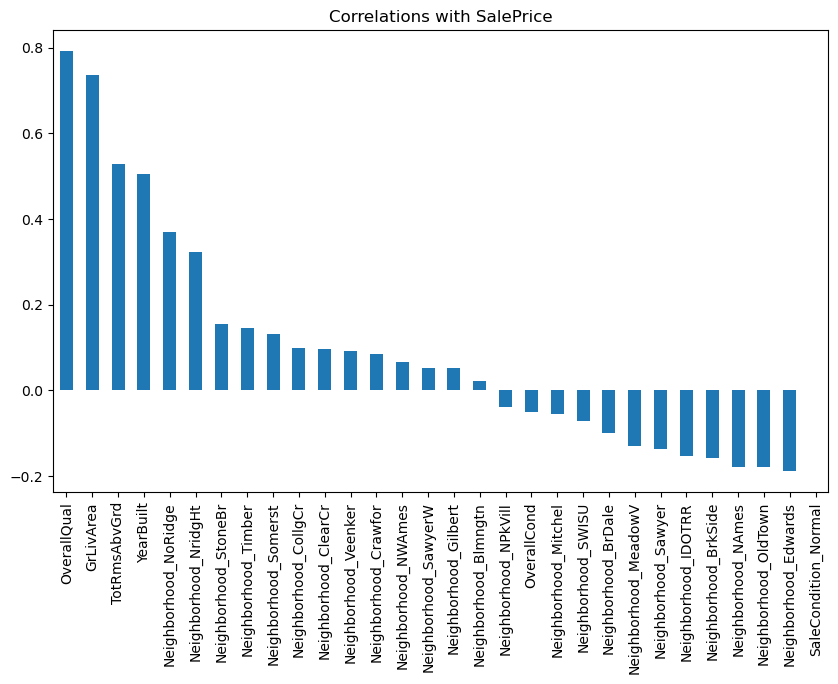

In [13]:
# Calculate correlations
correlations = dummies.corr()['SalePrice'].sort_values(ascending=False)

# Print correlations
print(correlations)

# Plot correlations
plt.figure(figsize=(10, 6))
correlations.drop('SalePrice').plot(kind='bar')
plt.title('Correlations with SalePrice')
plt.show()


In [14]:
# split data into target and features
y = dummies.SalePrice.values
X = dummies.drop(columns="SalePrice").values

# split data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42
)

# scale the data
scaler = StandardScaler()

# fit the scaler only to the training data
# to prevent data leakage (e.g., mean and standard deviation not modified by X_test and X_val)
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# df just to plot the data immediately below
scaled_df = pd.DataFrame(X_train, columns=dummies.drop(columns="SalePrice").columns)

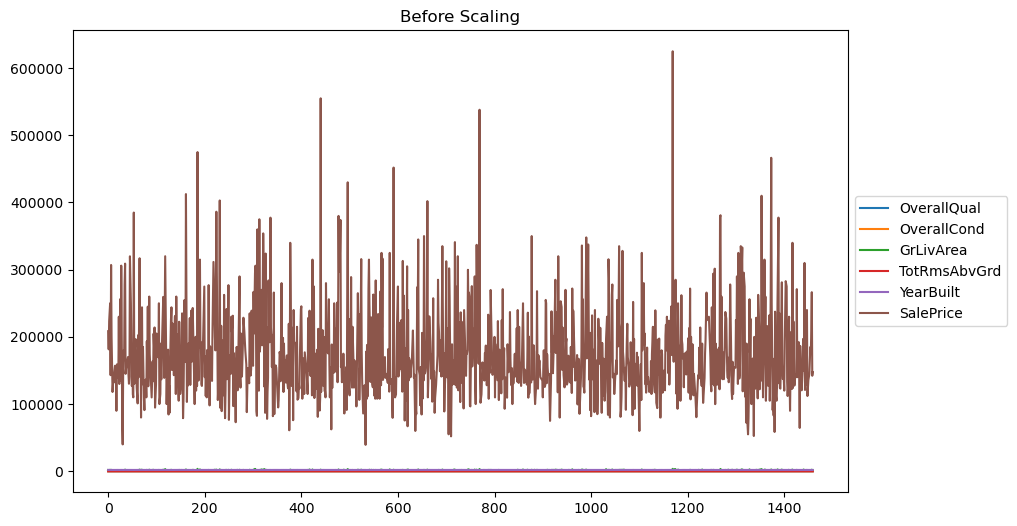

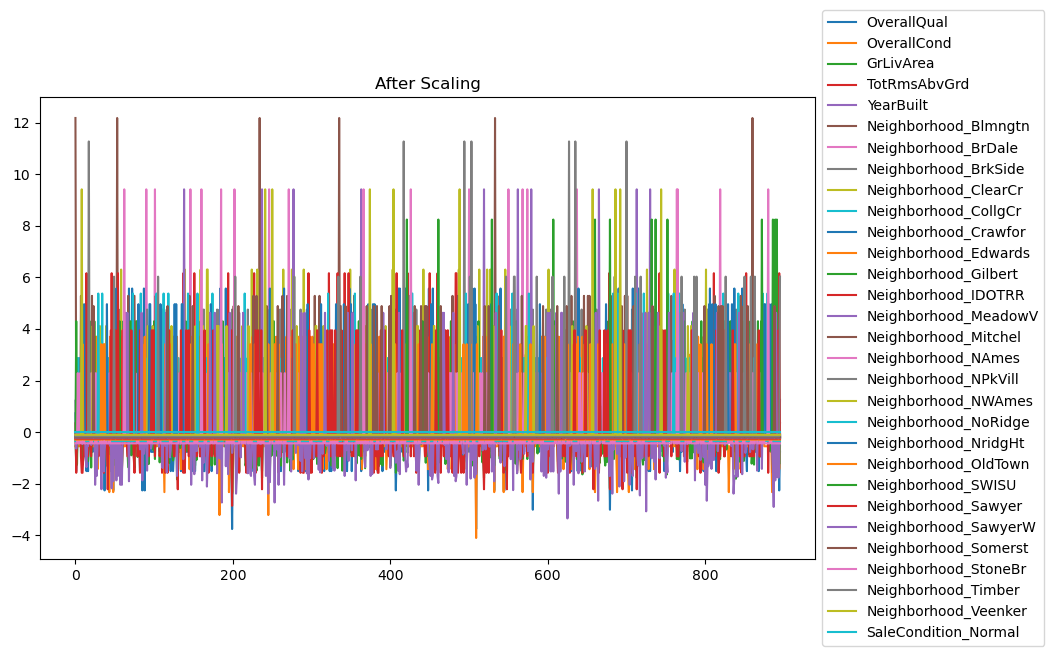

In [15]:
# plot data before scaling
dummies.plot(title='Before Scaling', figsize=(10, 6))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

# after scaling
scaled_df.plot(title='After Scaling', figsize=(10, 6))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

The outlier is in neighborhood

## Compile, Train, Evaluate the Model

In [16]:
# build keras-tuner function
def build_model(hp):
    nn_test = tf.keras.models.Sequential()

    # adds a range of 1 to 5 dense layers, allowable number of neurons (adjust based on features), activation functions
    for i in range(hp.Int("num_layers", min_value=1, max_value=4, step=1)):
        nn_test.add(
            tf.keras.layers.Dense(
                units=hp.Int(f"layer{i}", min_value=20, max_value=300, step=2),
                input_dim=len(X_train[0]),
                activation=hp.Choice(f"activation{i}", values=["relu", "tanh", "LeakyReLU"])
            )
        )

    # add final layer
    nn_test.add(tf.keras.layers.Dense(units=1, activation="linear"))

    # compile the model
    nn_test.compile(
        loss="mean_absolute_error",
        optimizer="adam",
        metrics=["mae"],
    )

    return nn_test

In [17]:

# define tuner / call the build_model function
tuner = RandomSearch(build_model, objective="mae", max_trials=10, overwrite=True)

# run the damn thing
tuner.search(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_val, y_val),
)

Trial 10 Complete [00h 00m 13s]
mae: 14012.2841796875

Best mae So Far: 14012.2841796875
Total elapsed time: 00h 01m 58s


In [18]:
# summary of results
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name="mae", direction="min")

Trial 09 summary
Hyperparameters:
num_layers: 4
layer0: 50
activation0: tanh
layer1: 86
activation1: relu
layer2: 200
activation2: LeakyReLU
layer3: 204
activation3: relu
Score: 14012.2841796875

Trial 03 summary
Hyperparameters:
num_layers: 3
layer0: 180
activation0: relu
layer1: 54
activation1: LeakyReLU
layer2: 164
activation2: LeakyReLU
layer3: 102
activation3: tanh
Score: 15794.3720703125

Trial 01 summary
Hyperparameters:
num_layers: 4
layer0: 64
activation0: LeakyReLU
layer1: 20
activation1: relu
layer2: 20
activation2: relu
layer3: 20
activation3: relu
Score: 16646.041015625

Trial 07 summary
Hyperparameters:
num_layers: 2
layer0: 230
activation0: relu
layer1: 130
activation1: relu
layer2: 204
activation2: LeakyReLU
layer3: 116
activation3: LeakyReLU
Score: 17696.630859375

Trial 06 summary
Hyperparameters:
num_layers: 3
layer0: 142
activation0: relu
layer1: 212
activati

In [19]:
# get the best hyperparameters from the tuner
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(best_hps.values)
print("---")

# build that model
nn = tuner.hypermodel.build(best_hps)

# add early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

# train the model
fit_model = nn.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
)

Best Hyperparameters:
{'num_layers': 4, 'layer0': 50, 'activation0': 'tanh', 'layer1': 86, 'activation1': 'relu', 'layer2': 200, 'activation2': 'LeakyReLU', 'layer3': 204, 'activation3': 'relu'}
---
Epoch 1/100
28/28 [==============================] - 1s 10ms/step - loss: 176382.5156 - mae: 176382.5156 - val_loss: 164035.1094 - val_mae: 164035.1094
Epoch 2/100
28/28 [==============================] - 0s 3ms/step - loss: 176228.1250 - mae: 176228.1250 - val_loss: 163623.5625 - val_mae: 163623.5625
Epoch 3/100
28/28 [==============================] - 0s 3ms/step - loss: 175060.2812 - mae: 175060.2812 - val_loss: 161115.0000 - val_mae: 161115.0000
Epoch 4/100
28/28 [==============================] - 0s 3ms/step - loss: 169604.0781 - mae: 169604.0781 - val_loss: 150603.3281 - val_mae: 150603.3281
Epoch 5/100
28/28 [==============================] - 0s 3ms/step - loss: 149658.6250 - mae: 149658.6250 - val_loss: 115286.3516 - val_mae: 115286.3516
Epoch 6/100
28/28 [==========================

In [20]:
# summarize final model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 50)                1550      
                                                                 
 dense_6 (Dense)             (None, 86)                4386      
                                                                 
 dense_7 (Dense)             (None, 200)               17400     
                                                                 
 dense_8 (Dense)             (None, 204)               41004     
                                                                 
 dense_9 (Dense)             (None, 1)                 205       
                                                                 
Total params: 64545 (252.13 KB)
Trainable params: 64545 (252.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
# print weights, just because
all_weights = nn.get_weights()
for i, layer_weights in enumerate(all_weights):
    print(f"Layer {i} Weights:")
    print(layer_weights)

Layer 0 Weights:
[[-0.37457561 -0.30858517  0.00844048 ... -0.0305281   0.14669368
   0.15841897]
 [-0.10345774  0.08213393  0.10778508 ...  0.25765893  0.06174912
  -0.13705277]
 [-0.00367071 -0.252375   -0.05056868 ...  0.23791683  0.44012067
  -0.18452106]
 ...
 [ 0.58880776 -0.02042934 -0.52881515 ... -0.3696958  -0.47149122
  -0.34880352]
 [ 0.2656097   0.5027758   0.2018731  ...  0.31029293  0.48844355
  -0.21953723]
 [-0.18940079  0.24682152 -0.08337766 ... -0.11805053  0.02898082
   0.16793305]]
Layer 1 Weights:
[-0.32180342 -0.33278212  0.32664815  0.22110139  0.28578097  0.29418546
 -0.2026485   0.3601883   0.25775447 -0.0814603  -0.19957978  0.180987
  0.288523   -0.3771516   0.32603943 -0.39681998 -0.31702748 -0.25294328
  0.13602392 -0.3870757  -0.27880558 -0.36473477 -0.405578   -0.06041577
 -0.10225874 -0.23526311  0.38038588  0.28380224  0.39249587  0.1929836
  0.23499054 -0.3765373  -0.30911553 -0.341832   -0.40083548  0.33269006
 -0.29805127 -0.280112    0.32724902 -0

In [22]:
# revert scaled data for testing predictions
y_test_pred=nn.predict(X_test)

5/5 [==============================] - 0s 2ms/step


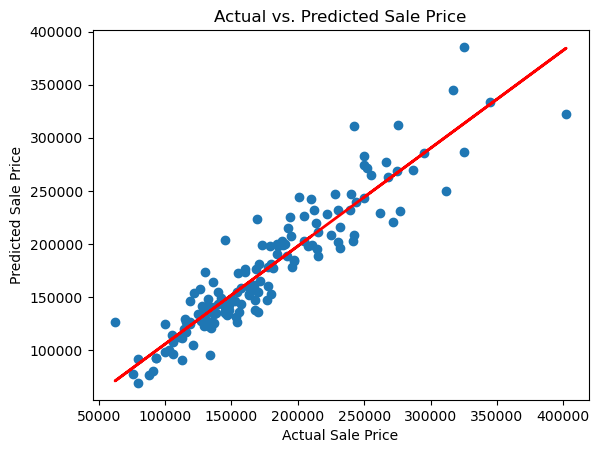

In [23]:
# Scatter plot for actual vs. predicted Sale Price
plt.scatter(y_test, y_test_pred.flatten())
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Actual vs. Predicted Sale Price")

# Add a line of best fit
fit = np.polyfit(y_test.flatten(), y_test_pred.flatten(), 1)
line = np.poly1d(fit)
plt.plot(y_test.flatten(), line(y_test.flatten()), color="red", linewidth=2)

plt.show()

In [24]:
# print the r_squared
print(f"R-squared: {r2_score(y_test, y_test_pred)}")

# and other metrics
print(f"Mean Squared Error: {mean_squared_error(y_test, y_test_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred)}")
print(f"Mean Percentage Error: {np.mean((y_test - y_test_pred) / y_test) * 100}")

R-squared: 0.8610794542530167
Mean Squared Error: 508690597.1606771
Mean Absolute Error: 16513.583541666667
Mean Percentage Error: -11.948130097769075


In [25]:
# predict a baseline
# essentially, set every value to the mean and create a fake list of predictions
# compare to above model's predictions
baseline_prediction = y_train.mean()

# create array of baseline predictions with the length of y_test
baseline_predictions = [baseline_prediction] * len(y_test)

print(f"Baseline R-squared: {r2_score(y_test, baseline_predictions)}")
print(
    f"Baseline Mean Squared Error: {mean_squared_error(y_test, baseline_predictions)}"
)
print(
    f"Baseline Mean Absolute Error: {mean_absolute_error(y_test, baseline_predictions)}"
)
print(
    f"Mean Percentage Error: {np.mean((y_test - baseline_predictions) / y_test) * 100}"
)

Baseline R-squared: -9.767483872025196e-05
Baseline Mean Squared Error: 3662095341.601121
Baseline Mean Absolute Error: 48139.728422619046
Mean Percentage Error: -12.500385305330964


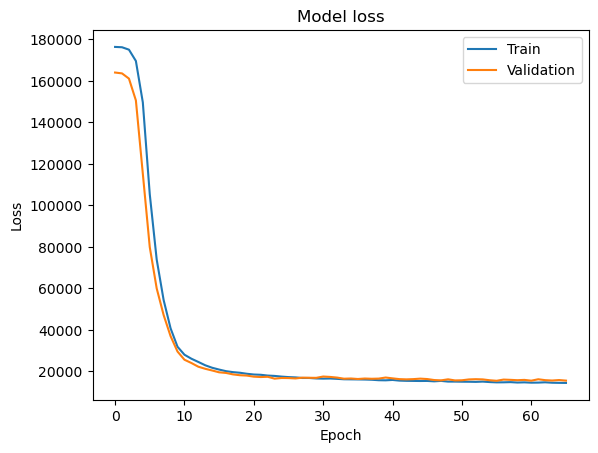

In [26]:
# plot training & validation loss values
# hopefully these both drop quickly and stabilize
# if not...
# validation loss up and training down? overfitting
# training and validation high? underfitting
plt.plot(fit_model.history["loss"])
plt.plot(fit_model.history["val_loss"])
plt.title("Model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc="upper right")
plt.show()

5/5 [==============================] - 0s 2ms/step


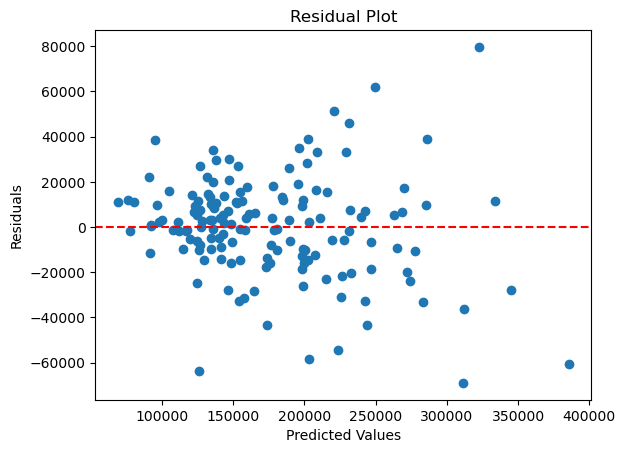

In [27]:
# residual plot
# difference between actual and predicted values
# you want there to be a rnadom distribution around the red line, zero
residuals = y_test - nn.predict(X_test).flatten()
plt.scatter(nn.predict(X_test).flatten(), residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

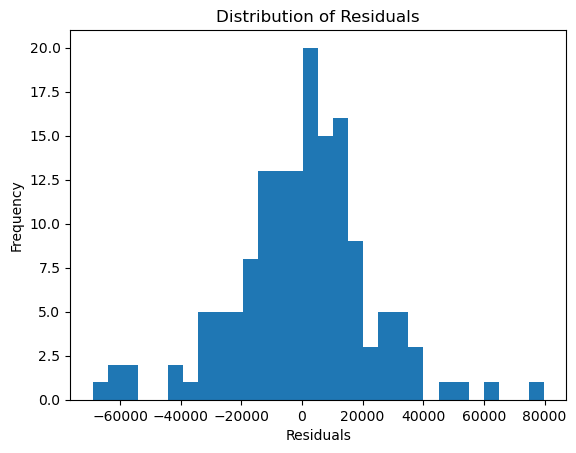

In [28]:
# distribution of residuals
plt.hist(residuals, bins=30)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()

In [29]:
# plot the learning curve?